In [1]:
import sys, os, re
from typing import *
sys.path = (["../src/", "../"] if re.match(r"^(\w\:\\)|(/)", os.getcwd()) else []) + sys.path
import qubx
%qubxd

%load_ext autoreload
%autoreload 2

from qubx import lookup, logger
from qubx.core.basics import DataType, Instrument, Signal, TimestampedDict
from qubx.core.interfaces import IStrategy, IStrategyContext, TriggerEvent, MarketEvent
from qubx.data.readers import InMemoryDataFrameReader, DataReader, AsDict, AsTrades, AsOhlcvSeries, AsBars, AsQuotes, AsTimestampedRecords, AsPandasFrame,RestoreTicksFromOHLC, RestoredBarsFromOHLC
from qubx.backtester.utils import _StructureSniffer
from qubx.core.metrics import tearsheet, chart_signals
from qubx.pandaz.utils import *
import qubx.ta.indicators as ta

# - - - - - - - - - - - - - - - - - - - - - - - -
from qubx.data.helpers import loader
from qubx.backtester.simulator import simulate

ld = loader("BINANCE.UM", "1h", source="csv::../tests/data/csv_1h", n_jobs=1)


⠀⠀⡰⡖⠒⠒⢒⢦⠀⠀   
⠀⢠⠃⠈⢆⣀⣎⣀⣱⡀  QUBX | Quantitative Backtesting Environment 
⠀⢳⠒⠒⡞⠚⡄⠀⡰⠁         (c) 2024, ver. Dev
⠀⠀⠱⣜⣀⣀⣈⣦⠃⠀⠀⠀ 
        


### <s>Current approach </s>

In [6]:
class TestA(IStrategy):
    """ Document your strategy here """
    timeframe: str = "15Min"
    exchange = 'BINANCE.UM'

    def on_init(self, ctx: IStrategyContext):
        ctx.set_base_subscription(DataType.OHLC[self.timeframe])
        ctx.set_event_schedule("55 23 * * *")
        ctx.set_fit_schedule("50 23 * * 1")
        self._idx = 0
        self._to_test = [
            [self.find_instrument(s) for s in ["BTCUSDT", "ETHUSDT"]],
            [self.find_instrument(s) for s in ["BTCUSDT", "BCHUSDT", "LTCUSDT"]],
            [self.find_instrument(s) for s in ["BTCUSDT", "AAVEUSDT", "ETHUSDT"]],
            [self.find_instrument(s) for s in ["BCHUSDT"]],
        ]

    def on_fit(self, ctx: IStrategyContext):
        logger.info(f" -> subscribe : {self.lst(self._to_test[self._idx])}")
        ctx.set_universe(self._to_test[self._idx])
        self._idx += 1
        if self._idx >= len(self._to_test):
            self._idx = 0 

    def on_event(self, ctx: IStrategyContext, event: TriggerEvent) -> Optional[List[Signal]]:
        s = []
        logger.info(f"Trig: {self.lst(ctx.instruments)} --> {str({i.symbol: ctx.quote(i) for i in ctx.instruments})}")
        if 1:
            for i in ctx.instruments:
                data = ctx.ohlc(i, self.timeframe)
                s1 = ta.kama(data.close, 36) - ta.kama(data.close, 12)
                if len(s1) > 1:
                    if s1[1] < 0 and s1[0] > 0:
                        logger.info(f"BUY: {i}")
                        s.append(ctx.instruments[0].signal(+1))

                    if s1[1] > 0 and s1[0] < 0:
                        logger.info(f"SELL: {i}")
                        s.append(i.signal(-1))
        return s

    def find_instrument(self, symbol: str) -> Instrument:
        return lookup.find_symbol(self.exchange, symbol) # type: ignore

    def lst(self, instrs: list[Instrument]):
        return ','.join(map(lambda x: x.symbol, instrs))


In [ ]:
r = simulate(
   # {'A': TestA(timeframe="1h")}, ld, 1000, 
   variate(TestA, timeframe=["15Min", "30Min", "1h"]), ld, 1000, 
   ['BINANCE.UM:BTCUSDT'],
   "vip0_usdt", "2023-07-01", "2023-07-30", debug="DEBUG"
)

,,Gain,Cagr,Sharpe,Qr,Max dd pct,Mdd usd,Sortino,Calmar,Tail ratio,Stability,Var,Avg return,Fees,Execs
id,,,,,,,,,,,,,,,
0,TA_(t=15Min),-659.24220,-0.999998,3.041389,-0.574773,106.709664,2215.990000,14.924458,-1.114604,2.524995,0.291326,1328.670529,14.507123,30.51720,4.0
2,TA_(t=1h),-668.58825,-0.999999,3.020462,-0.590899,106.811806,2220.000000,14.826988,-1.114604,2.536118,0.305066,1330.357952,14.414770,30.68325,4.0
1,TA_(t=30Min),-27.31788,-0.286085,-3.623893,-0.144373,4.877510,48.775097,-4.355597,-10.472455,0.000000,0.193378,8.682623,-0.091148,1.94288,2.0


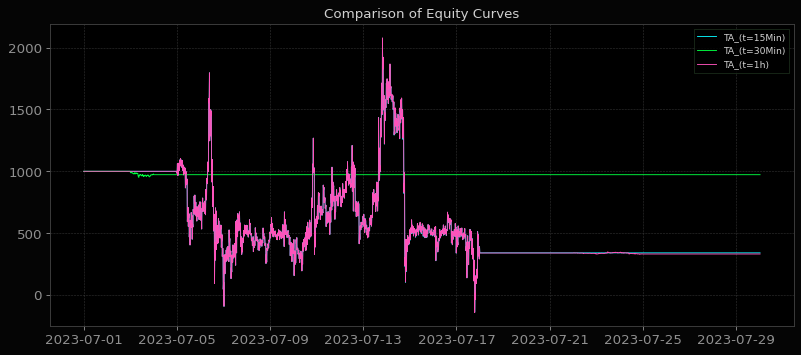

In [4]:
tearsheet(r, False, use_plotly=False)

In [5]:
r[2].config()

"TestA(timeframe='1h', exchange='BINANCE.UM')"

In [ ]:
# chart_signals(r[0], 'BTCUSDT', ld[['BTCUSDT']], show_signals=True)

## <font color='#00ff00'>-> New approach</font>

In [2]:
# - real data from CSV
l1 = loader("BINANCE.UM", "1h", source="csv::../tests/data/csv_1h", n_jobs=1)

# - 'real' quotes provider
rnd = lambda n: np.random.randn(n)  # noqa: E731
idx = pd.date_range(start="2023-06-01 00:00", end="2023-07-30", freq="5Min", name="timestamp")
q_data = pd.DataFrame({"bid": rnd(len(idx)), "ask": rnd(len(idx)), "bid_vol": rnd(len(idx)), "ask_vol": rnd(len(idx)) }, index=idx)
qts_reader = InMemoryDataFrameReader({"BINANCE.UM:BTCUSDT": q_data})

# - any data provider
idx = pd.date_range(start="2023-06-01 00:00", end="2023-07-30", freq="1h", name="timestamp")
c_data = pd.DataFrame({"value1": rnd(len(idx)), "value2": rnd(len(idx))}, index=idx)
custom_reader = InMemoryDataFrameReader({"BINANCE.UM:BTCUSDT": c_data})

In [3]:
class TestB(IStrategy):
    ma_period: str = "15Min"
    apply_own_schedule = False
    show_mkt = False

    def on_init(self, ctx: IStrategyContext):
        if self.apply_own_schedule: ctx.set_event_schedule("0 */1 * * *")
        # ctx.set_warmup({
        #     DataType.OHLC['1h']: "24h"
        # })

    def on_market_data(self, ctx: IStrategyContext, data: MarketEvent) -> list[Signal] | Signal | None:
        if self.show_mkt:
            logger.info(f'{data.instrument.symbol} market event ::: <g>{data.type}</g>\t:::  -> {data.data}')

    def on_event(self, ctx: IStrategyContext, event: TriggerEvent) -> list[Signal] | None:
        s = []

        if False:
            for i in ctx.instruments:
                data = ctx.ohlc(i, self.ma_period, 100)
                s1 = ta.ema(data.close, 12) - ta.ema(data.close, 3)
                if i.symbol == "BTCUSDT":  # debug output for BTCUSDT only
                    logger.info(f"<r>{i}</r>: {s1[1]}, {s1[0]}")
                if len(s1) > 1:
                    if s1[1] < 0 and s1[0] > 0:
                        logger.info(f" >> BUY: {i}")
                        s.append(i.signal(+1))

                    if s1[1] > 0 and s1[0] < 0:
                        logger.info(f"SELL: {i}")
                        s.append(i.signal(-1))
        return s

In [8]:
CFGS = [

   l1,                                     # 0 - just reader

   l1[['BTCUSDT'], "2023-06-01":"now"],    # 1 - as dict with dataframes

   {'ohlc': l1},                           # 2 - as specified ohlc

   {'ohlc(4h)': l1},                       # 3 - as 4h - we want to get triggers on 4h bars close

   {'ohlc(6h)': l1[['BTCUSDT']] },         # 4 - as 6h from predefined data

   {                                       # 5 - ohlc + real quotes / trades + custom data
      'ohlc(1h)': l1,                     
      # 'trade': l1, 
      'quote': l1, 
      # 'quote': qts_reader, 
      # '<r>MY_DATA</r>': custom_reader
    },
]

r = simulate({'CrossOver MA': TestB(show_mkt=1, apply_own_schedule=0, ma_period="1h")}, 

   CFGS[5],

   # 1000, ['BINANCE.UM:BTCUSDT', 'BINANCE.UM:ETHUSDT'], 
   1000, ['BINANCE.UM:BTCUSDT'], 
   # 1000, ['BINANCE.UM:ETHUSDT'], 
   # "vip0_usdt", "2023-07-01", "2023-07-30", debug="DEBUG",
   "vip0_usdt", "2023-07-10", "2023-07-11", debug="DEBUG",
   enable_event_batching=False, n_jobs=1
)

2023-07-10 00:00:00.000 [🐞] Preparing simulated trading on BINANCE.UM for 1000 x 1.0 in USDT...
2023-07-10 00:00:00.000 [ℹ️] SimulatedDataProvider.binance.um is initialized


Simulating:   0%|          | 0/100 [00:00<?, ?%/s]

2023-07-10 00:00:00.000 [🐞]  | Setting up default base subscription: ohlc(1h)
2023-07-10 00:00:00.000 [🐞]  | Setting default schedule: 0 */1 * * *
2023-07-10 00:00:00.000 [🐞] Strategy doesn't set warmup period for ohlc(1h) so default 2h will be used
2023-07-10 00:00:00.000 [🐞]  | Subscribing to: ohlc_quotes
2023-07-10 00:00:00.000 [ℹ️] SimulatedDataProvider ::: Simulation started at 2023-07-10 00:00:00 :::
2023-07-10 00:00:00.000 [🐞] Preloading initial data for ohlc.1h 2023-07-10 00:00:00 : 2023-07-11 00:00:00 ...
2023-07-10 00:00:00.000 [🐞] Preloading initial data for ohlc.1h 2023-07-10 00:00:00 : 2023-07-11 00:00:00 ...
2023-07-10 00:00:01.000 [🐞] Invoking TestB on_fit
2023-07-10 00:00:01.000 [🐞] TestB is fitted
2023-07-10 00:24:00.000 [ℹ️] BTCUSDT market event ::: ohlc	:::  -> {o:30147.800000 | h:30219.400000 | l:30147.800000 | c:30219.400000 | v:8186.595675}
2023-07-10 00:36:00.000 [ℹ️] BTCUSDT market event ::: ohlc	:::  -> {o:30147.800000 | h:30219.400000 | l:29928.800000 | c:2992

In [9]:
d1 = l1.read("BINANCE.UM:BTCUSDT", "2023-07-10 12:00:00", "-100h", transform=AsOhlcvSeries('1h'))
s1 = ta.ema(d1.close, 12) - ta.ema(d1.close, 3)

In [10]:
s1.pd().tail(10)

2023-07-10 03:00:00    28.851864
2023-07-10 04:00:00    34.702666
2023-07-10 05:00:00    48.527800
2023-07-10 06:00:00    48.567065
2023-07-10 07:00:00    35.847748
2023-07-10 08:00:00    32.866672
2023-07-10 09:00:00    14.608012
2023-07-10 10:00:00   -10.232807
2023-07-10 11:00:00   -36.709092
2023-07-10 12:00:00   -19.298359
Name: minus(ema(3,init_mean=True)), dtype: float64

In [ ]:
r[0].executions_log.loc['2023-07-19':'2023-07-20']

,Gain,Cagr,Sharpe,Qr,Max dd pct,Mdd usd,Sortino,Calmar,Tail ratio,Stability,Var,Avg return,Fees,Execs
CrossOver MA,-337.187,-1.0,-37.25,-0.554,88.518,909.0,-21.615,-8.566,0.508,1.0,292.421,-18.316,15.087,1.0


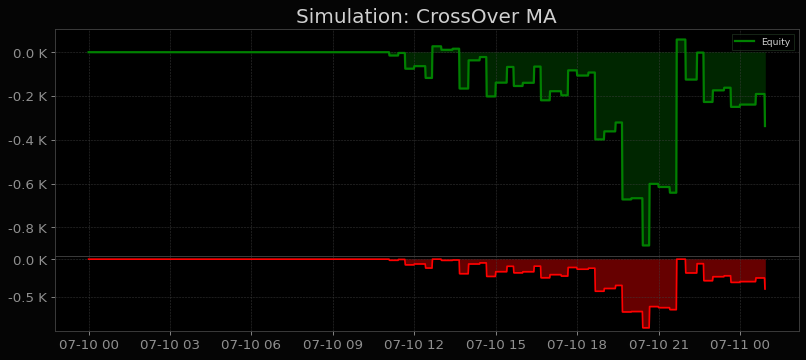

In [17]:
tearsheet(r, False, plot_leverage=0)


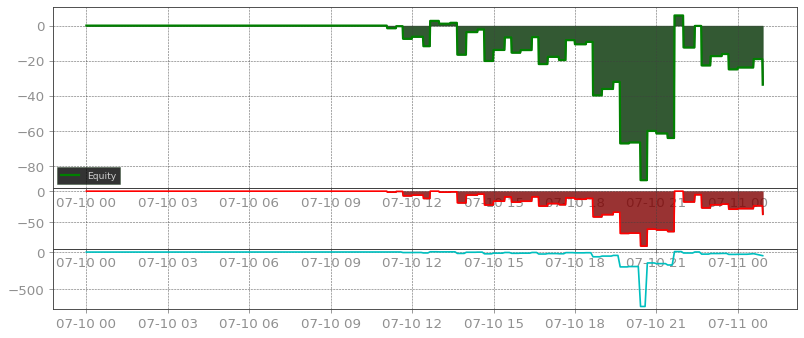

In [15]:
r[0].to_html()

In [16]:
r[0].to_file("test")

In [ ]:
chart_signals(r[0], 'BTCUSDT', l1[['BTCUSDT']], show_signals=True, show_trades=True)

In [ ]:
r[0].portfolio_log

## Triggering time

In [4]:
class TestC(IStrategy):
    apply_own_schedule = False
    show_mkt = False

    def on_init(self, ctx: IStrategyContext):
        if self.apply_own_schedule: 
            ctx.set_event_schedule("1 */4 * * *")
        # ctx.set_warmup({
        #     DataType.OHLC['1h']: '1d'
        # })

    def on_market_data(self, ctx: IStrategyContext, data: MarketEvent) -> list[Signal] | Signal | None:
        if self.show_mkt:
            logger.info(f'{data.instrument.symbol} market event ::: <g>{data.type}</g>\t:::  -> {data.data}')

    def on_event(self, ctx: IStrategyContext, event: TriggerEvent) -> list[Signal] | None:
        s = []

        # for i in ctx.instruments:
            # data = ctx.ohlc(i, '1h', 100)
            # logger.info(data)
        if 1: 
            logger.info(f'<r> === Event {ctx.time()} ::: {ctx.quote(ctx.instruments[0])} ===</r>')
        return s

In [5]:
r = simulate({'A': (stg:=TestC(show_mkt=0, apply_own_schedule=0))}, 
   # qts_reader,
   {
      'ohlc(4h)': l1, 
      # 'trade': l1, 
      # 'quote': l1, 
      # 'quote': qts_reader, 
   #    # '<y>quote1</y>': qts_reader, 
      # '<r>MY_DATA</r>': custom_reader
    },

   1000, ['BINANCE.UM:BTCUSDT', 'BINANCE.UM:ETHUSDT' ], 
   "vip0_usdt", "2023-07-01", "2023-07-03", debug="DEBUG", 
   enable_event_batching=True,
   # open_close_time_indent_secs=5
)

2023-07-02 00:59:59.000 [🐞] TestC new parameters:
	set show_mkt <- 0
	set apply_own_schedule <- 0


2024-12-27 16:59:26.235 [ ℹ️ ] (utils) >>>>>>>>>>> dict_keys([ohlc])
2023-07-01 00:00:00.000 [🐞] Preparing simulated trading on BINANCE.UM for 1000 x 1.0 in USDT...
2023-07-01 00:00:00.000 [ℹ️] SimulatedDataProvider.binance.um is initialized
2023-07-01 00:00:00.000 [🐞]  | Setting up default base subscription: ohlc(1h)


Simulating:   0%|          | 0/100 [00:00<?, ?%/s]

2023-07-01 00:00:00.000 [🐞]  | Setting default schedule: 0 */4 * * *
2023-07-01 00:00:00.000 [ℹ️] STG warmup: ohlc(1h) -> None
2023-07-01 00:00:00.000 [ℹ️] SimulatedDataProvider ::: Simulation started at 2023-07-01 00:00:00 :::
2023-07-01 00:00:00.000 [🐞] Preloading initial data for ohlc.1h 2023-07-01 00:00:00 : 2023-07-03 00:00:00 ...
2023-07-01 00:00:00.000 [🐞] (InMemoryCachedReader) Updating 2 symbols post interval 2023-07-02 00:00:00 : 2023-07-03 00:00:00
2023-07-01 00:00:01.000 [🐞] Invoking TestC on_fit
2023-07-01 00:00:01.000 [🐞] TestC is fitted
2023-07-01 04:00:00.000 [ℹ️]  === Event 2023-07-01T04:00:00.000000000 ::: [2023-07-01T03:59:59.000000000]	30391.15000 (0.0) | 30391.25000 (0.0) ===
2023-07-01 08:00:00.000 [ℹ️]  === Event 2023-07-01T08:00:00.000000000 ::: [2023-07-01T07:59:59.000000000]	30448.05000 (0.0) | 30448.15000 (0.0) ===
2023-07-01 12:00:00.000 [ℹ️]  === Event 2023-07-01T12:00:00.000000000 ::: [2023-07-01T11:59:59.000000000]	30508.45000 (0.0) | 30508.55000 (0.0) ==

# Initial quote and history

In [21]:
l1 = loader("BINANCE.UM", "1h", source="csv::../tests/data/csv_1h", n_jobs=1)

In [25]:
class TestD(IStrategy):
    show_mkt = False
    _n_f = 0

    def on_init(self, ctx: IStrategyContext):
        ctx.set_fit_schedule("0 */4 * * *")
        ctx.set_event_schedule("0 */4 * * * 2")
        self._n_f = 0
        # ctx.set_warmup({ DataType.OHLC: '24h' })
        # ctx.set_warmup({ DataType.OHLC['1h']: '24h' })
        # ctx.set_warmup({ DataType.OHLC['4h']: '24h' })

    def on_fit(self, ctx: IStrategyContext):
        logger.info("<C>------ FIT -------</C>")
        self._n_f += 1
        if self._n_f == 2:
            n_i = ctx.query_instrument("ETHUSDT")
            ctx.set_universe(ctx.instruments + [n_i])

    def on_market_data(self, ctx: IStrategyContext, data: MarketEvent) -> list[Signal] | Signal | None:
        if self.show_mkt:
            logger.info(f'{data.instrument.symbol} market event ::: <g>{data.type}</g>\t:::  -> {data.data}')

    def on_event(self, ctx: IStrategyContext, event: TriggerEvent) -> list[Signal] | None:
        for i in ctx.instruments:
            logger.info(f"\t - <y>{i.symbol} :: {ctx.quote(i)}</y>")
            logger.info(f"{ctx.ohlc(i, '1h')}")

r = simulate({'A': (stg:=TestD(show_mkt=0))}, { 'ohlc(4h)': l1 },
   1000, ['BINANCE.UM:BTCUSDT' ],
   "vip0_usdt", "2023-07-01", "2023-07-02", debug="DEBUG", 
#    enable_event_batching=True,
   open_close_time_indent_secs=1
)

2023-07-01 00:00:00.000 [🐞] Preparing simulated trading on BINANCE.UM for 1000 x 1.0 in USDT...


Simulating:   0%|          | 0/100 [00:00<?, ?%/s]

2023-07-01 00:00:00.000 [ℹ️] SimulatedDataProvider.binance.um is initialized
2023-07-01 00:00:00.000 [🐞]  | Setting up default base subscription: ohlc(1h)
2023-07-01 00:00:00.000 [ℹ️] Strategy doesn't set warmup period for ohlc(1h) so default 2h will be used
2023-07-01 00:00:00.000 [ℹ️] SimulatedDataProvider ::: Simulation started at 2023-07-01 00:00:00 :::
2023-07-01 00:00:00.000 [🐞] Preloading initial data for ohlc.1h 2023-07-01 00:00:00 : 2023-07-02 00:00:00 ...
2023-07-01 00:00:01.000 [🐞] Invoking TestD on_fit
2023-07-01 00:00:01.000 [ℹ️] ------ FIT -------
2023-07-01 00:00:01.000 [🐞] TestD is fitted
2023-07-01 00:00:02.000 [ℹ️] 	 - BTCUSDT :: [2023-07-01T00:00:01.000000000]	30460.15000 (0.0) | 30460.25000 (0.0)
2023-07-01 00:00:02.000 [ℹ️] BTCUSDT[1h] | 1 records
  2023-07-01T00:00:00.000000000 {o:30460.200000 | h:30460.200000 | l:30460.200000 | c:30460.200000 | v:0.000000}

2023-07-01 04:00:00.000 [🐞] Invoking TestD on_fit
2023-07-01 04:00:00.000 [ℹ️] ------ FIT -------
2023-07-0

2023-07-02 00:59:59.000 [ℹ️] SimulatedDataProvider ::: Simulation finished at 2023-07-02 00:00:00 :::
2023-07-02 00:59:59.000 [🐞] (InMemoryCachedReader) Loading all data 2023-06-01 00:00:00 - 2024-12-27 17:53:15.913245 for BTCUSDT 
2023-07-02 00:59:59.000 [🐞] TestB new parameters:
	set show_mkt <- 0
	set apply_own_schedule <- 0
	set ma_period <- 1h


# Set universe | subscribe tests

In [ ]:
l1 = loader("BINANCE.UM", "1h", source="csv::../tests/data/csv_1h", n_jobs=1)

class TestD(IStrategy):
    _n_f = 0
    test_n = "set_universe"

    def on_init(self, ctx: IStrategyContext):
        ctx.set_fit_schedule("0 */4 * * *")
        ctx.set_event_schedule("0 */4 * * * 1")
        ctx.set_warmup({ DataType.OHLC['1h']: '4h' })
        self._n_f = 0

    def on_fit(self, ctx: IStrategyContext):
        logger.info("<R>||| FIT |||</R>")
        self._n_f += 1
        if self._n_f == 2:
            n_i = ctx.query_instrument("ETHUSDT")

            if self.test_n == "set_universe":
                ctx.set_universe(ctx.instruments + [n_i])

            if self.test_n == "subscribe":
                ctx.subscribe(ctx.get_base_subscription(), n_i)

    def on_event(self, ctx: IStrategyContext, event: TriggerEvent) -> list[Signal] | None:
        for i in ctx.instruments:
            logger.info(f'\t<y>{i.symbol} ::: {ctx.quote(i)}</y>')

r = simulate({
        'A': TestD(test_n="set_universe"),
        'B': TestD(test_n="subscribe")
    }, { 'ohlc(4h)': l1 },
   1000, ['BINANCE.UM:BTCUSDT' ], "vip0_usdt", "2023-07-01", "2023-07-02", debug="DEBUG", 
)

# Formed deals (TODO)

In [189]:
T = pd.Timestamp

S = pd.DataFrame({ 
    'BTCUSDT': {
            T("2024-01-10 15:08:59.716000"): {'signal': 1, 'exec_price': 10000.1},
            T("2024-01-10 15:10:52.679000"): {'signal': 1, 'exec_price': 10000.1},
            T("2024-01-10 15:32:44.798000"): {'signal': 1, 'exec_price': 10000.1},
            T("2024-01-10 15:59:55.303000"): {'signal': 1, 'exec_price': 10000.1},
            T("2024-01-10 16:09:00.970000"): {'signal': 1, 'exec_price': 10000.1},
            T("2024-01-10 16:12:34.233000"): {'signal': 1, 'exec_price': 10000.1},
            T("2024-01-10 19:04:00.905000"): {'signal': 1, 'exec_price': 10000.1},
            T("2024-01-10 19:44:37.785000"): {'signal': 1, 'exec_price': 10000.1},
            T("2024-01-10 20:06:00.322000"): {'signal': 1, 'exec_price': 10000.1},
        }
    }
)

In [190]:
S.

,BTCUSDT
2024-01-10 15:08:59.716,"{'signal': 1, 'exec_price': 10000.1}"
2024-01-10 15:10:52.679,"{'signal': 1, 'exec_price': 10000.1}"
2024-01-10 15:32:44.798,"{'signal': 1, 'exec_price': 10000.1}"
2024-01-10 15:59:55.303,"{'signal': 1, 'exec_price': 10000.1}"
2024-01-10 16:09:00.970,"{'signal': 1, 'exec_price': 10000.1}"
2024-01-10 16:12:34.233,"{'signal': 1, 'exec_price': 10000.1}"
2024-01-10 19:04:00.905,"{'signal': 1, 'exec_price': 10000.1}"
2024-01-10 19:44:37.785,"{'signal': 1, 'exec_price': 10000.1}"
2024-01-10 20:06:00.322,"{'signal': 1, 'exec_price': 10000.1}"


In [186]:
_StructureSniffer()._is_signal(S)

True

In [95]:
s = pd.Timestamp("2022-01-01 1:00:00.10020000").to_datetime64().item() / 1000000000.0
min(np.datetime64(int(s * 1000000000), 'ns'), np.datetime64(datetime.max).astype('datetime64[s]'))

numpy.datetime64('9999-12-31T23:59:59')

In [ ]:
r[0].to_html()

In [31]:
r[0].to_file("Test2")

<Figure size 960x400 with 0 Axes>

In [33]:
str(r[0].creation_time)

'2024-12-19 15:35:56.545740'

In [ ]:
tearsheet(r[0], plot_leverage=1)

# Misc

In [38]:
from qubx.utils.time import handle_start_stop

In [54]:
handle_start_stop(pd.Timestamp("2023-07-01"), "now", convert=pd.Timestamp)

[Timestamp('2023-07-01 00:00:00'), Timestamp('2024-12-27 12:22:51.563422')]